In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from scipy import stats
import numpy as np
from torchsummary import summary
from sklearn.metrics import r2_score, mean_squared_error
import math
import argparse
import time
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

In [14]:
train_x = np.genfromtxt('../../processed_data/Xtrain', delimiter=',', dtype='float')
train_y = np.genfromtxt('../../processed_data/ytrain', delimiter=',', dtype='float')

test_x = np.genfromtxt('../../processed_data/Xtest', delimiter=',', dtype='float')
test_y = np.genfromtxt('../../processed_data/ytest', delimiter=',', dtype='float')

In [15]:
print('Data Loading finished (row:{})'.format(len(train_x)))

Data Loading finished (row:7676)


In [16]:
batch_size=32

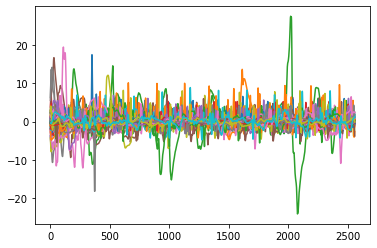

In [17]:
X = train_x
# plot random X
for i in range(100):
    plt.plot(X[400+i, :])
    
plt.savefig('cinc17_random_1_window_dataset.png', edgecolor='black', dpi=600)

In [39]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.kernel_size = 7
        self.padding_size = 0
        self.channel_size = 16
        self.avgpool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.avgpool2 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.avgpool3 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.avgpool4 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv1d(1, self.channel_size, kernel_size=self.kernel_size,
                               padding=(self.kernel_size // 2))
        self.conv2 = nn.Conv1d(self.channel_size, self.channel_size, kernel_size=self.kernel_size,
                               padding=(self.kernel_size // 2))
        self.conv3 = nn.Conv1d(self.channel_size, self.channel_size, kernel_size=self.kernel_size,
                               padding=(self.kernel_size // 2))
        self.conv4 = nn.Conv1d(self.channel_size, self.channel_size, kernel_size=self.kernel_size,
                               padding=(self.kernel_size // 2))
        self.fc1 = nn.Linear(2560, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # 32
        x = self.avgpool1(x)  # 32
        x = F.relu(self.conv2(x))
        x = self.avgpool2(x)
        x = F.relu(self.conv3(x))
        x = self.avgpool3(x)
        x = F.relu(self.conv4(x))
        x = self.avgpool4(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = self.fc3(x)
        return y

model = Net()

fan weights 7 0.5773502691896257 0.21821789023599236 0.3779644730092272
fan weights 112 0.5773502691896257 0.05455447255899809 0.0944911182523068
fan weights 112 0.5773502691896257 0.05455447255899809 0.0944911182523068
fan weights 112 0.5773502691896257 0.05455447255899809 0.0944911182523068
fan weights 2560 0.5773502691896257 0.01141088661469096 0.019764235376052368
fan_in bias 2560
fan weights 64 0.5773502691896257 0.07216878364870322 0.12499999999999999
fan_in bias 64
fan weights 64 0.5773502691896257 0.07216878364870322 0.12499999999999999
fan_in bias 64


In [40]:
from torchsummary import summary
summary(model, input_size=(1, 2560), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [32, 16, 2560]             128
         AvgPool1d-2             [32, 16, 1280]               0
            Conv1d-3             [32, 16, 1280]           1,808
         AvgPool1d-4              [32, 16, 640]               0
            Conv1d-5              [32, 16, 640]           1,808
         AvgPool1d-6              [32, 16, 320]               0
            Conv1d-7              [32, 16, 320]           1,808
         AvgPool1d-8              [32, 16, 160]               0
            Linear-9                   [32, 64]         163,904
           Linear-10                   [32, 64]           4,160
           Linear-11                    [32, 4]             260
Total params: 173,876
Trainable params: 173,876
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.31
Forward/

In [41]:
class ECGDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).float()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    def __len__(self):
        return len(self.data)
    
train_dataset = ECGDataset(train_x, train_y, transform=False)
test_dataset = ECGDataset(test_x, test_y, transform=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01, eps=1e-7)

In [36]:
val_x = torch.from_numpy(test_x).float()
val_y = torch.from_numpy(test_y).float()

In [37]:
train_x.shape

(7676, 2560)

In [42]:
def train(epoch):
    tr_loss = 0.0
    val_loss = 0.0
    model.train()
    for batch_idx, data in enumerate(train_loader):
        # get the inputs
        tr_inputs, tr_labels = data
        
        # get the validation set
        x_val, y_val = Variable(val_x), Variable(val_y)

        # zero the parameter gradients
        optimizer.zero_grad()

        # unsqueeze data
        tr_inputs = tr_inputs.unsqueeze(1)
        val_inputs = x_val.unsqueeze(1)

        # one-hot to label
        tr_labels = torch.argmax(tr_labels, dim=1)
        val_labels = torch.argmax(y_val, dim=1)

        # forward + backward + optimize
        tr_outputs = model(tr_inputs)
        val_outputs = model(val_inputs)
        
        # loss
        loss_train = criterion(tr_outputs, tr_labels)
        loss_val = criterion(val_outputs, val_labels)
        train_losses.append(loss_train)
        val_losses.append(loss_val)
        
        # computing the updated weights of all the model parameters
        loss_train.backward()
        optimizer.step()

        # print statistics
        tr_loss += loss_train.item()
        val_loss += loss_val.item()
        if batch_idx % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] train loss: %.6f, val loss : %.6f' %
                  (epoch + 1, batch_idx + 1, tr_loss / 100, val_loss / 100))
            tr_loss = 0.0
            val_loss = 0.0


In [ ]:
# defining the number of epochs
n_epochs = 10
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)
    
print('Finish Training')

[1,   100] train loss: 1.325106, val loss : 1.324937


In [ ]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
import sklearn.metrics as skm
report = skm.classification_report(
            ground_truth, preds,
            target_names=preproc.classes,
            digits=3)
scores = skm.precision_recall_fscore_support(
                    ground_truth,
                    preds,
                    average=None)
print(report)